In [18]:
import os
import random
import yaml as yaml
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch

import sys
sys.path.append("../utils")
sys.path.append("../finetune/")
from finetune_dataset import getdataset as get_zero_dataset
import utils_builder
from zeroshot_val import zeroshot_eval
from torch.utils.data.dataloader import DataLoader
sys.path.append("../report_generate/")
from models.merl import ECGCLIP

os.environ["TOKENIZERS_PARALLELISM"] = "true"

device_id = 'cuda:0'

config = yaml.load(open("zeroshot_config.yaml", "r"), Loader=yaml.FullLoader)

torch.manual_seed(42)       
random.seed(0)
np.random.seed(0)

# model = utils_builder.ECGCLIP(config['network'])
# ckpt = '/home/chenjian/multi-modal_ECG/merl/MERL/zeroshot/78.72/resnet_mix_sep_bestZeroShotAll_ckpt.pth'

model = ECGCLIP(config['network'])
ckpt = '/home/chenjian/multi-modal_ECG/merl/MERL/chec/res18_best_ckpt.pth'
ckpt = torch.load(f'{ckpt}', map_location='cpu')
model.load_state_dict(ckpt)
model = model.to(device_id)
model = torch.nn.DataParallel(model)

In [2]:
from finetune_dataset import getdataset

In [3]:
data_split_path = '/home/chenjian/multi-modal_ECG/MERL/finetune/data_split'
data_meta_path = '/data/chenjian/ECG_MM/downstream'

dataset ='ptbxl_super_class'

    # set the path where you store the ptbxl dataset
data_path = f'{data_meta_path}/ptbxl'
data_split_path = os.path.join(data_split_path, f'ptbxl/{dataset[6:]}')

train_csv_path = f'{dataset}_train.csv'
train_csv_path = os.path.join(data_split_path, train_csv_path)
val_csv_path = f'{dataset}_val.csv'
val_csv_path = os.path.join(data_split_path, val_csv_path)
test_csv_path = f'{dataset}_test.csv'
test_csv_path = os.path.join(data_split_path, test_csv_path)

train_dataset = getdataset(data_path, train_csv_path, mode='train', dataset_name='ptbxl', ratio=100,
                            backbone='resnet18')
# val_dataset = getdataset(data_path, val_csv_path, mode='val', dataset_name='ptbxl',
#                             backbone=args.backbone)
test_dataset = getdataset(data_path, test_csv_path, mode='test', dataset_name='ptbxl',
                            backbone='resnet18')

In [62]:
data_split_path = '/home/chenjian/multi-modal_ECG/MERL/finetune/data_split'
data_meta_path = '/data/chenjian/ECG_MM/downstream'
data_path = f'{data_meta_path}/ICBEB/records500'
data_split_path = os.path.join(data_split_path, 'icbeb')
dataset ='icbeb'


train_csv_path = f'{dataset}_train.csv'
train_csv_path = os.path.join(data_split_path, train_csv_path)
val_csv_path = f'{dataset}_val.csv'
val_csv_path = os.path.join(data_split_path, val_csv_path)
test_csv_path = f'{dataset}_test.csv'
test_csv_path = os.path.join(data_split_path, test_csv_path)

train_dataset = getdataset(data_path, train_csv_path, mode='train', dataset_name='icbeb', ratio=100,
                                backbone='resnet18')
val_dataset = getdataset(data_path, val_csv_path, mode='val', dataset_name='icbeb',
                                backbone='resnet18')
test_dataset = getdataset(data_path, test_csv_path, mode='test', dataset_name='icbeb',
                                backbone='resnet18')

In [50]:
data_split_path = '/home/chenjian/multi-modal_ECG/MERL/finetune/data_split'
data_meta_path = '/data/chenjian/ECG_MM/downstream'
dataset = 'chapman'
data_path = f'{data_meta_path}/'
data_split_path = os.path.join(data_split_path, dataset)

train_csv_path = f'{dataset}_train.csv'
train_csv_path = os.path.join(data_split_path, train_csv_path)
val_csv_path = f'{dataset}_val.csv'
val_csv_path = os.path.join(data_split_path, val_csv_path)
test_csv_path = f'{dataset}_test.csv'
test_csv_path = os.path.join(data_split_path, test_csv_path)

train_dataset = getdataset(data_path, train_csv_path, mode='train', dataset_name='chapman', ratio=100,
                            backbone='resnet18')
val_dataset = getdataset(data_path, val_csv_path, mode='val', dataset_name='chapman',
                            backbone='resnet18')
test_dataset = getdataset(data_path, test_csv_path, mode='test', dataset_name='chapman',
                            backbone='resnet18')

In [51]:
len(test_dataset)

4620

In [63]:
test_dataloader = DataLoader(
            test_dataset,
            batch_size=16,
            num_workers=1,
            pin_memory=True,
            sampler=None,
            shuffle=False,
            collate_fn=None,
            drop_last=False,
        )

In [77]:
ptbxl_emb = []
ptbxl_form = []
with torch.no_grad():
    for i, (ecg, target) in enumerate(tqdm(test_dataloader)):
        ecg = ecg.to(device='cuda:0') 
        # predict
        ecg_emb = model.module.ext_ecg_emb(ecg)
        ecg_emb /= ecg_emb.norm(dim=-1, keepdim=True)
        ptbxl_emb.append(ecg_emb)
        ptbxl_form.append(target)

100%|██████████| 86/86 [00:02<00:00, 31.32it/s]


In [78]:
ptbxl_emb = torch.cat(ptbxl_emb, dim=0)
ptbxl_form = torch.cat(ptbxl_form, dim=0)

In [79]:
ptbxl_emb.shape

torch.Size([1376, 256])

In [80]:
ptbxl_form = ptbxl_form.argmax(dim=1)

In [81]:
pd.Series(ptbxl_form).value_counts()

4    348
0    227
2    184
8    165
3    146
6    118
1    115
7     40
5     33
Name: count, dtype: int64

In [82]:
from sklearn.manifold import TSNE
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

In [90]:
X_I = TSNE(n_components=2, perplexity=50, random_state=42).fit_transform(ptbxl_emb.detach().cpu().numpy())

In [72]:
id = [2, 20, 36, 9, 31, 8, 6, 12, 14]
idx = np.where(np.isin(ptbxl_form, id))
X_I1  = X_I[idx]
ptbxl_form_1 = ptbxl_form[idx]

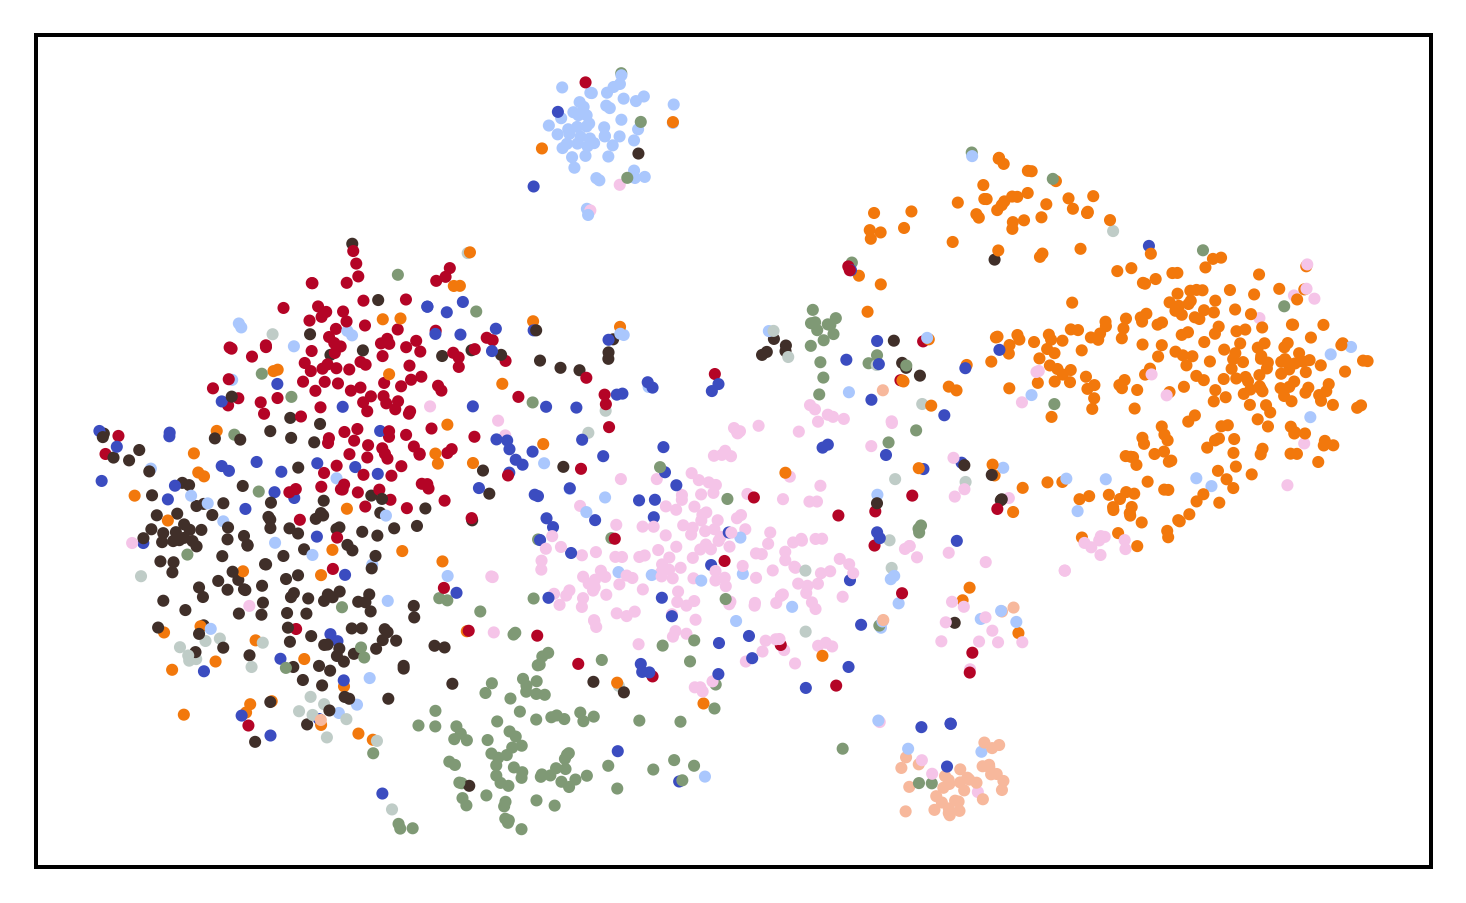

In [91]:
plt.figure(figsize=(5,3),dpi=360)
color_mapping = {0: '#F5C4E8', 1: '#aac7fd', 2: '#402F29', 3: '#7F9975', 4:'#F2780C', 5:'#BFCCC7', 
                  6:'#3b4cc0',7:'#f7b89c', 8:'#b40426'}
label_mapping = {0: '1AVB', 1: 'AF', 2: 'LBBB', 3: 'RBBB', 4:'NORMAL', 5:'PAC', 6:'STD', 7:'STE', 8:'PVC'}
custom_cmap = ListedColormap([color_mapping[0], color_mapping[1], color_mapping[2], color_mapping[3], color_mapping[4],
                               color_mapping[5],color_mapping[6],color_mapping[7], color_mapping[8]])
# color_mapping = {2: '#F5C4E8', 20: '#aac7fd', 36: '#402F29', 9: '#7F9975', 31:'#F2780C', 8:'#BFCCC7', 
#                   6:'#3b4cc0',12:'#f7b89c', 14:'#b40426'}
# custom_cmap = ListedColormap([color_mapping[2], color_mapping[20], color_mapping[36], color_mapping[31], color_mapping[6],
#                                color_mapping[8],color_mapping[6],color_mapping[12], color_mapping[14]])
# color_mapping = {0: '#3b4cc0', 1:'#b40426' , 2: '#aac7fd', 3: '#f7b89c', 4:'#F5C4E8'}
# label_mapping = {0: 'STTC', 1: 'Normal', 2: 'MI', 3: 'HYP', 4:'CD'}
# custom_cmap = ListedColormap([color_mapping[0], color_mapping[1], color_mapping[2], color_mapping[3], color_mapping[4]])

# legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label_mapping[label], 
#                              markersize=5, markerfacecolor=color_mapping[label]) for label in np.unique(ptbxl_form)]

plt.scatter(X_I[:, 0], X_I[:, 1], c=ptbxl_form[:], s=2, cmap=custom_cmap)
# plt.legend(handles=legend_handles, prop={'size': 6}, loc='upper center',ncol=9, bbox_to_anchor=(0.5, 1.1))
#plt.title('T-SNE on CPSC2018')  
plt.xticks([])
plt.yticks([])  
plt.show()                                                                                    
#plt.savefig(r'./fig/CPSC2018.eps',dpi=360)

In [89]:
plt.figure(figsize=(5,3),dpi=360)
# color_mapping = {0: '#F5C4E8', 1: '#aac7fd', 2: '#402F29', 3: '#7F9975', 4:'#F2780C', 5:'#BFCCC7', 
#                   6:'#3b4cc0',7:'#f7b89c', 8:'#b40426'}
# label_mapping = {0: '1AVB', 1: 'AF', 2: 'LBBB', 3: 'RBBB', 4:'NORMAL', 5:'PAC', 6:'STD', 7:'STE', 8:'PVC'}
# custom_cmap = ListedColormap([color_mapping[0], color_mapping[1], color_mapping[2], color_mapping[3], color_mapping[4],
#                                color_mapping[5],color_mapping[6],color_mapping[7], color_mapping[8]])
# color_mapping = {2: '#F5C4E8', 20: '#aac7fd', 36: '#402F29', 9: '#7F9975', 31:'#F2780C', 8:'#BFCCC7', 
#                   6:'#3b4cc0',12:'#f7b89c', 14:'#b40426'}
# custom_cmap = ListedColormap([color_mapping[2], color_mapping[20], color_mapping[36], color_mapping[31], color_mapping[6],
#                                color_mapping[8],color_mapping[6],color_mapping[12], color_mapping[14]])
color_mapping = {0: '#3b4cc0', 1:'#b40426' , 2: '#aac7fd', 3: '#f7b89c', 4:'#F5C4E8'}
label_mapping = {0: 'STTC', 1: 'Normal', 2: 'MI', 3: 'HYP', 4:'CD'}
custom_cmap = ListedColormap([color_mapping[0], color_mapping[1], color_mapping[2], color_mapping[3], color_mapping[4]])

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label_mapping[label], 
                             markersize=5, markerfacecolor=color_mapping[label]) for label in np.unique(ptbxl_form)]

plt.scatter(X_I[:, 0], X_I[:, 1], c=ptbxl_form[:], s=1, cmap=custom_cmap)
# plt.legend(handles=legend_handles, prop={'size': 6}, loc='upper center',ncol=9, bbox_to_anchor=(0.5, 1.1))
#plt.title('T-SNE on CPSC2018')  
plt.xticks([])
plt.yticks([])  
plt.show()                                                                                    
#plt.savefig(r'./fig/CPSC2018.eps',dpi=360)

KeyError: 5

<Figure size 1800x1080 with 0 Axes>